<a href="https://colab.research.google.com/github/aleksandr-gerasymenko/disease-recognition-from-x-ray/blob/master/disease_recognition_from_x_rayV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hi all

At first you need download dataset (PNEUMONIA) from kaggle here
 https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

After that just run notebook 

Need download Dataset with Tuberculosis and Norm

In [ ]:
!wget https://www.dropbox.com/s/f64cvlhm0gp80v5/tuberculosis.zip?dl=1 -O tuberculosis.zip

Need unzip folder

In [ ]:
!jar xvf /content/tuberculosis.zip
!jar xvf /content/17810_23812_bundle_archive.zip

Create one main dir for 
NORMAL,PNEUMONIA,Tuberculosis

In [73]:
#prepare data from https://www.kaggle.com/kmader/pulmonary-chest-xray-abnormalities/home and from here https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
!rm -rf /content/chest_xray/chest_xray
!rm -rf /content/chest_xray/__MACOSX
!rm -rf /content/chest_xray/val
!mv /content/base_dir/train_dir/Normal/* /content/chest_xray/train/NORMAL/
!mv /content/base_dir/val_dir/Normal/* /content/chest_xray/test/NORMAL/
!mv /content/base_dir/train_dir/Tuberculosis /content/chest_xray/train/Tuberculosis
!mv /content/base_dir/val_dir/Tuberculosis /content/chest_xray/test/Tuberculosis
!rm -rf /content/base_dir

Download modules

In [74]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy import loadtxt
import tensorflow.keras
from PIL import Image, ImageOps
%matplotlib inline

Set image size & batch size

In [75]:
image_size = 299
batch_size = 32

# Create image generator

In [76]:
# folders with train dir & val dir
train_dir = '/content/chest_xray/train/'
test_dir = '/content/chest_xray/test/'
input_shape = (image_size, image_size, 3)

Create image data generator for train data

In [77]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                              height_shift_range= 0.02, 
                              width_shift_range=0.02, 
                              rotation_range=0.02, 
                              shear_range = 0.01,
                              fill_mode='nearest',
                              zoom_range=0.01)

Check generator

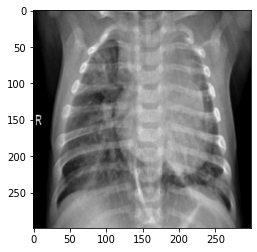

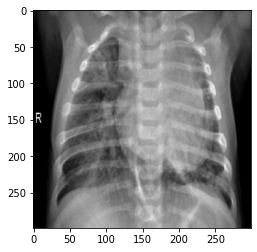

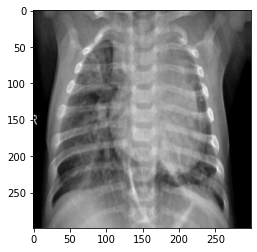

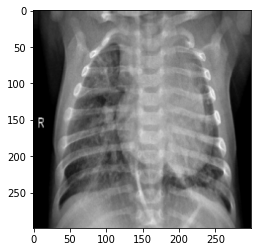

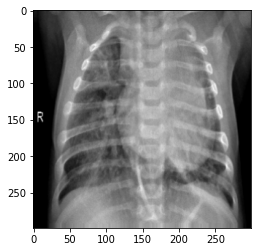

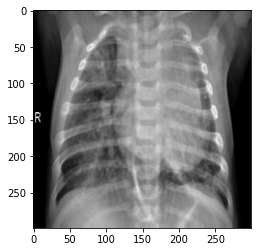

In [78]:
img_path = '/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
img = image.load_img(img_path, target_size=(image_size, image_size))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 6 == 0:
        break
plt.show()

Setting train generator

In [79]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 5896 images belonging to 3 classes.


Setting test generator without data augmentation

In [80]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 744 images belonging to 3 classes.


Print count classes

In [81]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1, 'Tuberculosis': 2}

Graph count images per classes "train"



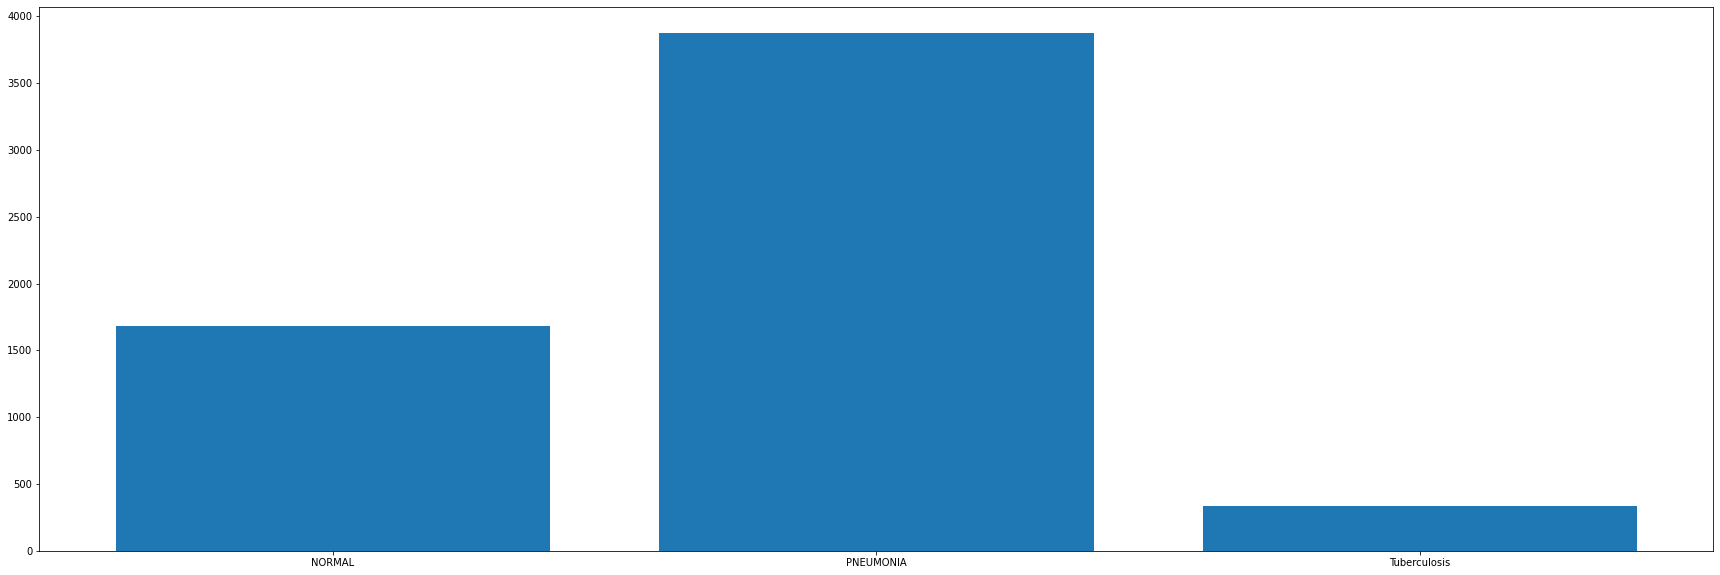

In [82]:
from sklearn.utils.class_weight import compute_class_weight
cls_train = train_generator.classes
from collections import OrderedDict
classes = list(train_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_train, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(3):
    num_values.append(valdict[i])
plt.figure(figsize=(30,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show()   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


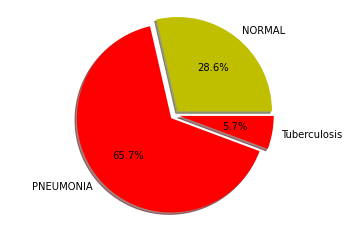

In [83]:
import matplotlib.pyplot as plt
goal_types = list(train_generator.class_indices.keys())
unique, counts = np.unique(cls_train, return_counts=True)
goals = [(counts)]
colors = ['y','r', 'r']
plt.pie(goals, labels = goal_types, colors=colors ,shadow = True, explode = (0.05, 0.05, 0.05), autopct = '%1.1f%%')
plt.axis('equal')
plt.show()

Graph count images per classes "test"

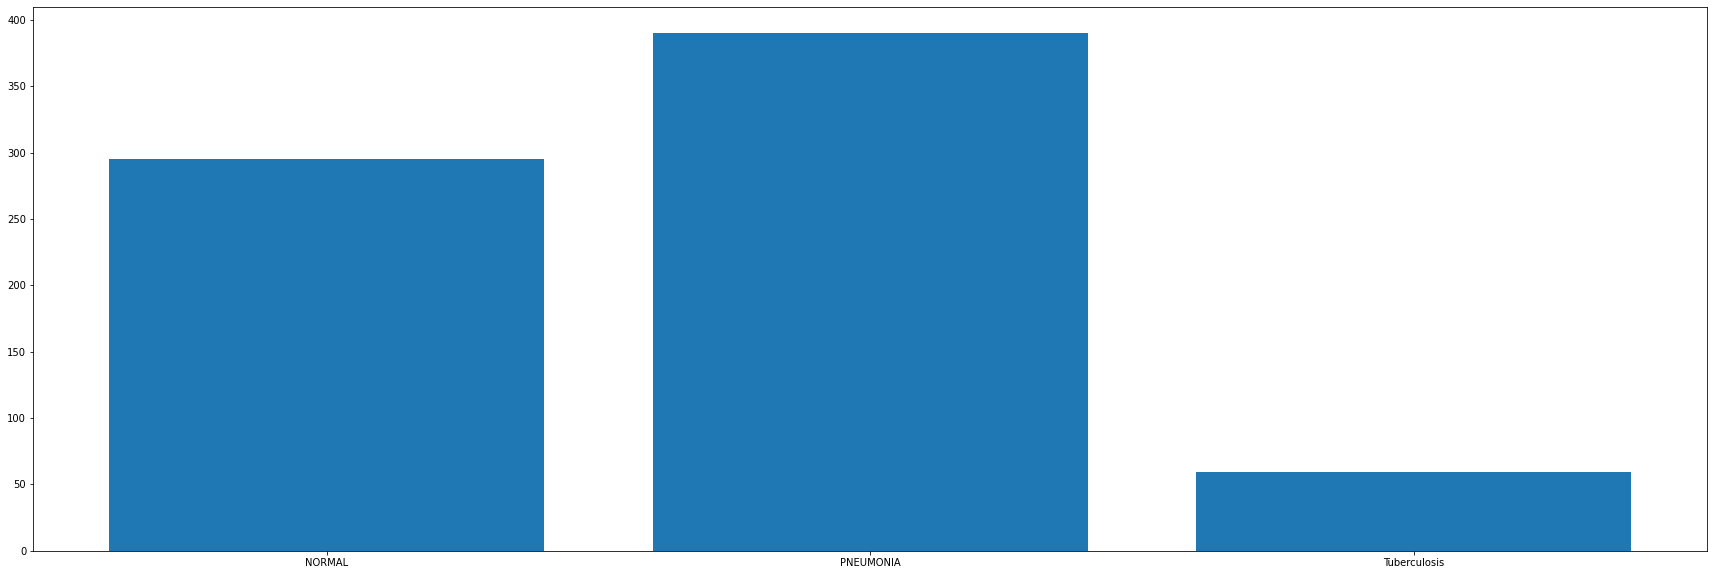

In [84]:
from sklearn.utils.class_weight import compute_class_weight
cls_test = test_generator.classes
from collections import OrderedDict


classes = list(test_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_test, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(3):
    num_values.append(valdict[i])
plt.figure(figsize=(30,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show() 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  import sys


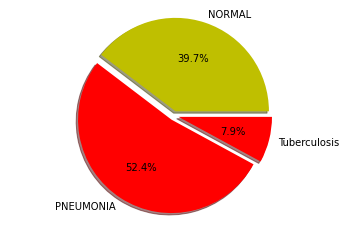

In [85]:
import matplotlib.pyplot as plt

goal_types = list(test_generator.class_indices.keys())
unique, counts = np.unique(cls_test, return_counts=True)
goals = [(counts)]
colors = ['y','r', 'r']
plt.pie(goals, labels = goal_types, colors=colors ,shadow = True, explode = (0.05, 0.05, 0.05), autopct = '%1.1f%%')
plt.axis('equal')

plt.show()

# Download Xception model

In [ ]:
pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False)
pretrained_model.summary()

"Frozen" all weights pretrained models 

In [ ]:
pretrained_model.trainable = False
pretrained_model.summary()

# Created main layers for end Xception model

In [88]:
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=predictions)

View all model before training

In [ ]:
model.summary()

# Train a composite neural network based on Xception

In [90]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=["accuracy"])

filepath="inceptionv3_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks_list = [checkpoint, learning_rate_reduction]

steps_per_epoch = 32
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=20,
    verbose=1)

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 0.4509 - accuracy: 0.8457
Epoch 00001: val_loss improved from inf to 0.84933, saving model to inceptionv3_best.h5
32/32 [==============================] - 30s 953ms/step - loss: 0.4509 - accuracy: 0.8457 - val_loss: 0.8493 - val_accuracy: 0.6125
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 0.2387 - accuracy: 0.9189
Epoch 00002: val_loss improved from 0.84933 to 0.78529, saving model to inceptionv3_best.h5
32/32 [==============================] - 30s 924ms/step - loss: 0.2387 - accuracy: 0.9189 - val_loss: 0.7853 - val_accuracy: 0.6687
Epoch 3/20
32/32 [==============================] - ETA: 0s - loss: 0.2025 - accuracy: 0.9170
Epoch 00003: val_loss did not improve from 0.78529
32/32 [==============================] - 29s 912ms/step - loss: 0.2025 - accuracy: 0.9170 - val_loss: 1.0663 - val_accuracy: 0.6438
Epoch 4/20
32/32 [==============================] - ETA: 0s - loss: 0.1845 - accuracy: 0.93


Visualize the history of network learning: accuracy

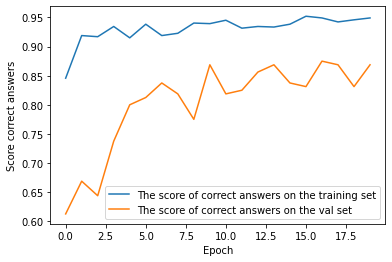

In [91]:
plt.plot(history.history['accuracy'], label='The score of correct answers on the training set')
plt.plot(history.history['val_accuracy'], label='The score of correct answers on the val set')
plt.xlabel('Epoch')
plt.ylabel('Score correct answers')
plt.legend()
plt.show()

Visualize the history of network learning: loss

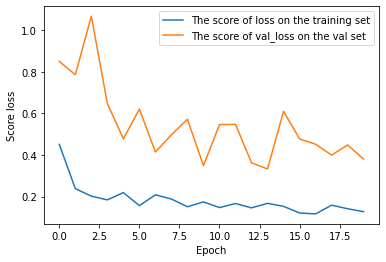

In [92]:
plt.plot(history.history['loss'], label='The score of loss on the training set')
plt.plot(history.history['val_loss'], label='The score of val_loss on the val set')
plt.xlabel('Epoch')
plt.ylabel('Score loss')
plt.legend()
plt.show()

# Fine tuning convolutional layers Xception

Download the best weights

In [93]:
model.load_weights("inceptionv3_best.h5")

Defrost the last 2 blocks of Xception

In [94]:
pretrained_model.trainable = False
for layer in model.layers[:290]:
   layer.trainable = False
for layer in model.layers[290:]:
   layer.trainable = True


Compile a network with defrosted layers. And start learning

In [95]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=["accuracy"])

filepath="inceptionv3_fine_tuned.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, learning_rate_reduction]


steps_per_epoch = 32
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=40,
    verbose=2)

Epoch 1/40

Epoch 00001: val_accuracy improved from -inf to 0.86250, saving model to inceptionv3_fine_tuned.h5
32/32 - 30s - loss: 0.1423 - accuracy: 0.9365 - val_loss: 0.4078 - val_accuracy: 0.8625
Epoch 2/40

Epoch 00002: val_accuracy did not improve from 0.86250
32/32 - 29s - loss: 0.1238 - accuracy: 0.9512 - val_loss: 0.3505 - val_accuracy: 0.8625
Epoch 3/40

Epoch 00003: val_accuracy improved from 0.86250 to 0.87500, saving model to inceptionv3_fine_tuned.h5
32/32 - 29s - loss: 0.1463 - accuracy: 0.9414 - val_loss: 0.3347 - val_accuracy: 0.8750
Epoch 4/40

Epoch 00004: val_accuracy did not improve from 0.87500
32/32 - 28s - loss: 0.1457 - accuracy: 0.9380 - val_loss: 0.3451 - val_accuracy: 0.8500
Epoch 5/40

Epoch 00005: val_accuracy did not improve from 0.87500
32/32 - 28s - loss: 0.1487 - accuracy: 0.9434 - val_loss: 0.3975 - val_accuracy: 0.8562
Epoch 6/40

Epoch 00006: val_accuracy did not improve from 0.87500
32/32 - 29s - loss: 0.1231 - accuracy: 0.9561 - val_loss: 0.3985 - 

Visualize the history of network learning: accuracy

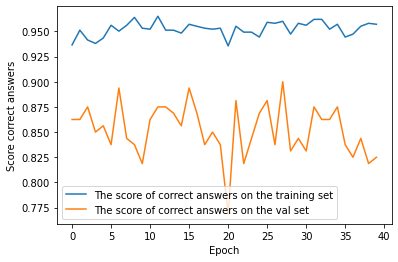

In [96]:
plt.plot(history.history['accuracy'], label='The score of correct answers on the training set')
plt.plot(history.history['val_accuracy'], label='The score of correct answers on the val set')
plt.xlabel('Epoch')
plt.ylabel('Score correct answers')
plt.legend()
plt.show()

Visualize the history of network learning: loss

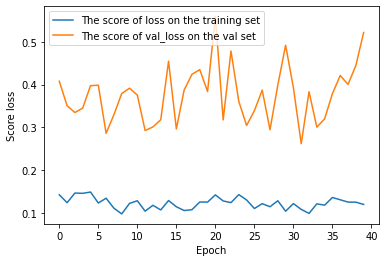

In [97]:
plt.plot(history.history['loss'], label='The score of loss on the training set')
plt.plot(history.history['val_loss'], label='The score of val_loss on the val set')
plt.xlabel('Epoch')
plt.ylabel('Score loss')
plt.legend()
plt.show()

Testing model and download the best weights

In [125]:
# Load the model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from PIL import Image, ImageOps
image_size = 256
batch_size = 32
model = tensorflow.keras.models.load_model('inceptionv3_best.h5')


Upload photo with PNEUMONIA

In [ ]:
!jar xvf /content/17810_23812_bundle_archive.zip

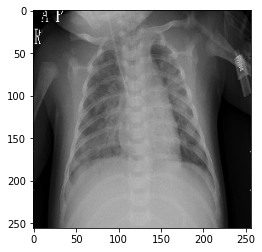

In [127]:
img_path = '/content/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg'
#img_path = '/content/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg' #norma

img = image.load_img(img_path, target_size=(image_size, image_size))
plt.imshow(img)
plt.show()

In [128]:
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

In [129]:
prediction = model.predict(x)

In [130]:
prediction

array([[6.3629396e-04, 9.9936372e-01, 5.7857282e-08]], dtype=float32)

List classes with numbers of classes:
'NORMAL': 0, 
'PNEUMONIA': 1, 
'Tuberculosis': 2

In [131]:
classes = np.argmax(prediction, axis = 1)
print(classes)

[1]
